In [1]:
from stable_baselines3 import PPO  # pip install stable-baselines3
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.utils import get_schedule_fn
from IPython import display
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym
import random
import glob
import os
from gym import Env, spaces
import time
from gym.wrappers import Monitor
import pandas as pd
import matplotlib.pyplot as plt
font = cv2.FONT_HERSHEY_COMPLEX_SMALL 

In [35]:
class Game(Env):
    def win(self):
        ob=self.ob
        w=0
        if(ob[0][0]==ob[0][1]==ob[0][2]==2):
            w=-1
        if(ob[1][0]==ob[1][1]==ob[1][2]==2):
            w=-1
        if(ob[2][0]==ob[2][1]==ob[2][2]==2):
            w=-1
        if(ob[0][0]==ob[0][1]==ob[0][2]==1):
            w=1
        if(ob[1][0]==ob[1][1]==ob[1][2]==1):
            w=1
        if(ob[2][0]==ob[2][1]==ob[2][2]==1):
            w=1


        if(ob[0][0]==ob[1][0]==ob[2][0]==2):
            w=-1
        if(ob[0][1]==ob[1][1]==ob[2][1]==2):
            w=-1
        if(ob[0][2]==ob[1][2]==ob[2][2]==2):
            w=-1        
        if(ob[0][0]==ob[1][0]==ob[2][0]==1):
            w=1
        if(ob[0][1]==ob[1][1]==ob[2][1]==1):
            w=1
        if(ob[0][2]==ob[1][2]==ob[2][2]==1):
            w=1


        if(ob[0][0]==ob[1][1]==ob[2][2]==2):
            w=-1
        if(ob[0][0]==ob[1][1]==ob[2][2]==1):
            w=1

        if(ob[0][2]==ob[1][1]==ob[2][0]==2):
            w=-1
        if(ob[0][2]==ob[1][1]==ob[2][0]==1):
            w=1
        return w
    def get_valid(self):
        arr=self.ob
        good=(-1,-1)
        i=0
        while(i<100):
            i+=1
            a,b=int(random.random()*3),int(random.random()*3)
            if(arr[a][b]==0):
                good=(a,b)
                break
        return good
    def __init__(self):
        self.ob=np.zeros((3,3))
        self.log=[]
        self.outcome=0
        self.left=9
        super(Game, self).__init__()
        

        
        self.observation_shape = (3,3)
        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape), 
                                            high = np.ones(self.observation_shape),
                                            dtype = np.float16)
    
        
        self.action_space = spaces.Discrete(9,)
                        
        self.canvas = np.ones((320, 320, 3)) * 1
        
        # Define elements present inside the environment
        self.elements = []
    def draw_elements_on_canvas(self):
        # Init the canvas 
        self.canvas = np.ones((320,320,3)) * 1
        
        # Draw the heliopter on canvas
        for elem in self.elements:
            #print(elem["x"]*100, elem["y"]*100)
            elem_shape = (80,80)
            x,y = elem.x*100+20, elem.y*100+20
            if(elem.name=="X"):
                self.canvas[y : y + elem_shape[1], x:x + elem_shape[0]] = 256-cv2.imread("New folder/X.png")
            else:
                self.canvas[y : y + elem_shape[1], x:x + elem_shape[0]] = 256-cv2.imread("New folder/O.png")
        cv2.imwrite(f'img/img_step_{9-self.left}.png', 256-self.canvas)
        #text = 'Fuel Left: {} | Rewards: {}'.format(self.fuel_left, self.ep_return)
        #text = 'Fuel Left: {} | Rewards: {}'.format(self.fuel_left, self.ep_return)
        text=""
        # Put the info on canvas 
        self.canvas = cv2.putText(self.canvas, text, (10,20), font,  
                   0.8, (0,0,0), 1, cv2.LINE_AA)

    def draw(self):
        
        self.log=[]
        self.outcome=0
        self.left=9
        self.ep_return  = 0

        self.elements = []

        self.canvas = np.ones((320,320,3)) * 1

        self.draw_elements_on_canvas()


        # return the observation
        return self.canvas 

    def reset(self):
        files = glob.glob('/img')
        for f in files:
            os.remove(f)
        self.outcome=0
        self.ob=np.zeros((3,3))
        self.log=[]
        self.left=9
        # Reset the reward
        self.ep_return  = 0

        # Intialise the elements 
        self.elements = []

        # Reset the Canvas 
        self.canvas = np.ones((320,320,3)) * 1

        # Draw elements on the canvas
        #self.draw_elements_on_canvas()


        # return the observation
        return np.zeros((3,3)) 
    
    def render(self, mode = "human"):
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        if mode == "human":
            cv2.imshow("Game", self.canvas)
            cv2.waitKey(10)

        elif mode == "rgb_array":
            return self.canvas

    def close(self):
        cv2.destroyAllWindows()

        env = Game()
        obs = env.reset()
        screen = env.render(mode = "rgb_array")
    def outcome(self):
        return self.outcome
    def step(self, action):
        if(len(str(action))>1):
            action=action[0]
        self.ob=np.zeros((3,3))
        done = False
        
        reward = 0

        place=((action)//3,action%3)
        action2=int(9*random.random())
        place2=((action2)//3,action2%3)
        
        for elem in self.elements:
            elem_x, elem_y = elem.get_position()
            if isinstance(elem, X):
                self.ob[elem_x][elem_y]=1
                
            elif isinstance(elem, O):
                self.ob[elem_x][elem_y]=2

        if(not self.ob[place]):
            self.left-=1
            self.elements.append(X("X",place[0],place[1]))
            self.ob[place[0]][place[1]]=1
            self.draw_elements_on_canvas()
            if(self.ob[place2]!=0 or place==place2):  
                
                place2=self.get_valid()
                if(place2!=(-1,-1)):
                    self.ob[place2]=2
                    self.left-=1
                    self.elements.append(O("O",place2[0],place2[1]))
                    self.draw_elements_on_canvas()
                else:
                    done=True
            else:
                self.ob[place2]=2
                self.left-=1
                self.elements.append(O("O",place2[0],place2[1]))
                self.draw_elements_on_canvas()

            for elem in self.elements:
                elem_x, elem_y = elem.get_position()
                if isinstance(elem, X):
                    self.ob[elem_x][elem_y]=1

                if isinstance(elem, O):
                    self.ob[elem_x][elem_y]=2

            
        else:
            reward=-10
            done=True
        if(self.left<1):
            done=True
        won=self.win()
        reward+=won
        if(won!=0):
            done=True
        self.ep_return += reward
        if(done):
            self.outcome=0
            error=int(self.ep_return<-1)
            if(error):
                won=-2
            self.outcome=["NOT VALID","LOSE","DRAW","WIN"][won+2]
            file=open("rewards.txt")
            st=file.read()
            file=open("rewards.txt","w")
            file.write(st+str(reward)+" ")
        return self.ob, reward, done, {}

In [36]:
class Point(object):
    def __init__(self, name, x, y):
        self.x = x
        self.y = y
        self.name = name
    
    def set_position(self, x, y):
        self.x = self.clamp(x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(y, self.y_min, self.y_max - self.icon_h)
    
    def get_position(self):
        return (self.x, self.y)
    
    def move(self, del_x, del_y):
        self.x += del_x
        self.y += del_y
        
        self.x = self.clamp(self.x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(self.y, self.y_min, self.y_max - self.icon_h)
        
        self.x=min(600,max(0,self.x))
        self.y=min(600,max(0,self.y))
    def clamp(self, n, minn, maxn):
        return max(min(maxn, n), minn)

In [37]:
class X(Point):
    def __init__(self, name, x, y):
        super(X, self).__init__(name, x, y)

    
class O(Point):
    def __init__(self, name, x, y):
        super(O, self).__init__(name, x, y)

In [11]:
env = Game()
model = PPO("MlpPolicy",env)
#model.load("models/rl_model_9391_248896_steps.zip")
run_id = int(10000*random.random())
print("Training model...")
print("id",run_id)

checkpoint_callback = CheckpointCallback(save_freq=1000,
                                         save_path='./models/',
                                         name_prefix=f'rl_model_{run_id}')
schedule = [
    (80000, 0.001),
    (20000, 0.0001),
]
for steps, learning_rate in schedule:
    model.lr_schedule = get_schedule_fn(learning_rate)
    model.learn(total_timesteps=steps,
                callback=checkpoint_callback,
                reset_num_timesteps = False)
    

model.save(path=f'models/model_final.zip')

print("Done training model.")

Training model...
id 836
Done training model.


In [12]:
file=open("rewards.txt")
rewards=list(map(int,file.read().split()))

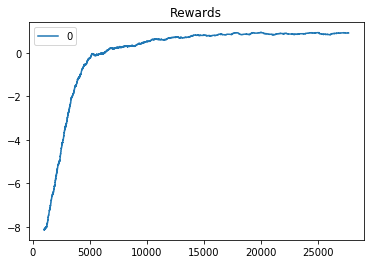

In [15]:
df = pd.DataFrame(rewards)
df.rolling(window=1000).mean().plot(title="Rewards")
plt.show()

In [38]:
env = Game()
obs = env.reset()
ress=[0,0,0,0]
num_steps=0
n=100
for i in range(n):
    arr=[]
    env = Game()
    obs = env.reset()
    while True:
        action=model.predict(obs)[0]
        obs, reward, done, canvas = env.step(action)
        if done == True:
            break
    outcome=env.outcome
    num_steps=9-env.left
    res=["NOT VALID","LOSE","DRAW","WIN"].index(outcome)
    ress[res]+=1
    env.close()
print(f"invalid plays {int(ress[0]/n*100)} % loses {int(ress[1]/n*100)} % draws {int(ress[2]/n*100)} % wins {int(ress[3]/n*100)} %")   

invalid plays 1 % loses 3 % draws 0 % wins 96 %


In [39]:
import cv2
import os

image_folder ="img/"
video_name = 'test.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")][:num_steps]

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

In [40]:
from IPython.display import HTML

HTML("""
    <video alt="test" controls>
        <source src="test.mp4" type="video/mp4">
    </video>
""")